## 多目标检测

Author: Lei Wang (lwang11@mtu.edu)
Date: July 15th, 2019

### Synthetic Dataset (See [Mask RCNN](https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb) )

对于多目标检测来说自由数据标注，难度更大，需要更专业的工具。为了克服这个问题，在小规模数据上，进行算法的实验和验证，我们可以通过合成数据集来完成带标注数据的采集，用来进行算法验证。

合成数据集通常用于仿真实验，常用的方法包括标准集合形状，3D仿真渲染等。Intel® `Carla`项目于2017年首次公开虚拟仿真的实验设备：用Ureal4构建的仿真场景，动态仿真障碍物，通过模拟MVP矩阵计算的虚拟照相机。随后多个团队进行了相关工程和算法的跟进和开发，成为GAN之后，最具有希望解决大规模数据标注用于模型训练的方法之一。

本文首先使用基于MaskRCNN `ShapeDataset`的`SyntheticDataset`生产数据，然后针对多目标算法重点对One-Stage, Two-Stage的检测方法在合成数据集上，进行了分析和实现，最后对街拍视频进行了实时分析。

### One-Stage Algorithm

单阶段检测方法，具有比较高的速度优势，非常适合实时性需求比较强的算法环境，比如高速行驶的无人车辆。通过剪枝和NAS优化，还可以达到更加小的体积和推理速度，从而非常合适在端部署。

##### YoloV4: YoloV3 with various optimization

##### SSD

最开始的实现是在caffe上做的，我们将用Tensorflow-Keras重新实现上面的的算法，并且运用最新的优化技巧。


### Two-Stage Algorithm


##### Maks-RCNN (implemented in PaddlePaddle)

In [4]:
import sys
print(sys.executable)
!pwd

# nvidia-smi executed from modelarts notebook does not work
# https://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib

def get_available_gpus():
  local_device_protos = device_lib.list_local_devices()
  return [device_proto for device_proto in local_device_protos if device_proto.device_type == 'GPU']

print(get_available_gpus())

/home/ma-user/anaconda3/envs/TensorFlow-1.8/bin/python
/home/ma-user/work
[name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15872484967
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10469243867300329198
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:0c.0, compute capability: 6.0"
]


In [5]:
'''
Created on 15 Jul, 2016

@author: wangyi
'''

import os
# from config import cfg
import importlib
import global_settings

ENVIRON_CONFIG = "config"

try:
  basestring
except NameError:
  basestring = str

class ImproperlyConfigured(Exception): pass

class Settings:

    def __init__(self, custom_settings=None):
        # update global settings
        for setting in dir(global_settings):
            if setting.isupper() and not setting.startswith("__"):
                setattr(self, setting, getattr(global_settings, setting))

        if custom_settings is None:
            custom_settings = os.environ.get(ENVIRON_CONFIG)
        if custom_settings is not None and isinstance(custom_settings, basestring):
            try:
                custom_settings = importlib.import_module(custom_settings)
            except Exception as ex:
                raise ImproperlyConfigured("")

        self._setting_module = custom_settings
        if custom_settings is not None:
            self._overriden_vals = set()
            for setting in dir(custom_settings):
                if setting.isupper():
                    val = getattr(custom_settings, setting)
                    # do some checking

                    # overriden
                    setattr(self, setting, val)
                    self._overriden_vals.add(setting)

    def __str__(self):
        ret = []
        ret.append("\nConfigurations:\n")
        for setting in dir(self):
            if setting.isupper() and not setting.startswith("__"):
                ret.append("{:30} {}\n".format(setting, getattr(self, setting)))
        ret.append("\n")
        return "".join(ret)

    def __repr__(self):
        return "<Setting Object: {}>".format(self._setting_module.__name__)

In [6]:
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Project Root
Project_ROOT = os.path.abspath(".")

%matplotlib inline

## 创建一个动态配置文件对象

Python提供了descriptor framework，各种工程实践表明，将配置文件通过，局部py配置文件（因为Python本身是动态语言，可以动态加载代码），读取配置文件的加载对象来完成比较好。

本例虽然是针对合成数据集做实验，但是仍然使用ImageNet作为预训练模型。因此要求输入图像至少满足`221x221`大小

In [7]:
# adapt codes from https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
class SyntheticDatasetConfig(Settings):
    """Configuration for training on the toy synthetic dataset.
    Derives from the base Config class and overrides values specific
    to the toy synthetic dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # dims
    BATCH_SIZE = 32
    
    # Used for our Image net pretrained model, at last to be 221x221
    IMAGE_SHAPE = [221, 221, 3]
    
    # Yolo loss Threshold, used for compute confidence
    IOU_LOSS_THRESH = 0.5
    
    # Anchors
    ANCHORS = {2: [(10,13),(16,30),(33,23)],      # large objects detect anchors
               1: [(30,61),(62,45),(59,119)],     # medium objects detect anchors
               0: [(116,90),(156,198),(373,326)]} # smallest detect anchors

config = SyntheticDatasetConfig()
print(config)


Configurations:
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_SHAPE                    [221, 221, 3]
IOU_LOSS_THRESH                0.5
NAME                           shapes
NUM_CLASSES                    4
RPN_ANCHOR_SCALES              (8, 16, 32, 64, 128)
STEPS_PER_EPOCH                100
TRAIN_ROIS_PER_IMAGE           32
VALIDATION_STEPS               5




In [8]:
'''
Created on 15 Jul, 2019

@author: wangyi
'''

# numpy array utils. 
# warning: the utilities should accept tensors as input.

def read_img(file_path):
    if not os.path.exists(file_path):
        raise ValueError("Image path [%s] does not exist." % (file_path))
    im = cv2.imread(file_path)
    im = im.astype(np.float32, copy=False)
    im = cv2.resize(im, (config.HEIGHT, config.WIDTH), interpolation=cv2.INTER_CUBIC)
    return im

def load_images(files):
    count = len(files)
    X = np.ndarray((count, config.HEIGHT, config.WIDTH, config.CHANNEL), dtype=np.uint8)
    for i, image_file in enumerate(files):
        image = read_img(image_file)
        X[i] = image
    return X

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def IoU_numeric(left_box, right_box, left_area, right_area):
    # Compute intersection areas
    x1 = max(left_box[0], right_box[0])
    y1 = max(left_box[1], right_box[1])
    x2 = min(left_box[2], right_box[2])
    y2 = min(left_box[3], right_box[3])
    
    h = max(0, y2 - y1)
    w = max(0, x2 - x1)
    
    overlap = float(w * h)
    union = left_area + right_area - overlap
    iou = overlap / union
    return iou

# Non-Max Suppression: simliar to tf.image.non_max_suppression for non-symbolic computation
# see https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py
def nms(boxes, scores=None, threshold=0.3):
    """
    @param boxes: np.array with standard tensorflow box order, [x1, y1, x2, y2]
    @param scores: np.array
    @param threshold: float32
    """
    if len(boxes) == 0:
        return 0
    
    # Compute box area: (x2 - x1) * (y2 - y1)
    area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
    
    if scores is not None:
        # Sort boxes indices by box scores
        idx = scores.argsort()[::-1]
    else:
        # see https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
        # Sort boxes indices by bottom-right y-coordinates of bounding box
        idx = np.argsort(boxes[:,3])
        
    picked = []
    
    while len(idx) > 0:
        # Pick one to the list
        i = idx[0]
        picked.append(i)
        # Compute IoU of the picked box with the rest
        ious = np.array([IoU_numeric(boxes[i], boxes[j], area[i], area[j]) for j in idx[1:]])
        remove_idx = np.where(ious > threshold)[0] + 1
        # Remove indices of overlapped boxes
        idx = np.delete(idx, remove_idx)
        idx = np.delete(idx, 0)
    return np.array(picked, dtype=np.int32)
    

In [9]:
'''
Created on 20 May, 2019

@author: wangyi
'''

import cv2
import numpy as np
from skimage.measure import find_contours

# visualization toolkits

def save_instances(image, boxes, masks, class_ids, class_names, scores):
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)
    scores = scores or [1.0] * n_instances
    
    if not n_instances:
        print("No instances to display!")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]
    
    masked_image = image.copy()
    out = masked_image
    
    for i in range(n_instances):
        color = colors[i]
        
        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        
        y1, x1, y2, x2 = boxes[i]
        mask = masks[:, :, i]
        
        class_id = class_ids[i]
        score = scores[i]
        label = class_names[class_id]
        
        if label is not 'person':
            continue;
        
        caption = "{} {:.3f}".format(label, score) if score else label
        
        masked_image = apply_mask(masked_image, mask, color)
        masked_image_with_boxes = cv2.rectangle(masked_image, (x1, y1), (x2, y2), color, 2)
        
        # Mask Polygon
        padded_mask = np.zeros(
          (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8
        )
        padded_mask[1:-1, 1:-1] = mask
        # contours = find_contours(padded_mask, 0.5)
        _, contours, _ = cv2.findContours(padded_mask, 
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        masked_image_with_contours_plus_boxes = cv2.drawContours(masked_image_with_boxes, contours, -1, (0, 255, 0), 1)
        
        out = cv2.putText(
            masked_image_with_contours_plus_boxes, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

        masked_image = out
    return out

def display(im, ax=None):
    figsize = (16,16)
    if ax is None:
        _, ax = plt.subplots(1, figsize=figsize)
    height, width = im.shape[:2]
    size = (width, height)
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.imshow(im.astype(np.uint8))
    return ax
    
def set_title(ax, caption):
    ax.set_title(caption, fontsize=9)
    

In [10]:
# Author: Lei Wang
# Date: July 15th, 2019
# Email: lwang11@mtu.edu, lwang019@e.ntu.edu.sg, L.WANG@ntu.edu.sg, yiak.wy@gmail.com


import os # path, directory utilities
import cv2
import glob # used for extract images from data_path
from sklearn.model_selection import train_test_split
import colorsys

# @todo : TODO
class Dataset:

    def __init__(self, name):
        self._name = name
        self._class_names = []
        self._data_path = None
        self._dataset_path = None
        self._dataset_meta = {}
        self._images_info = []
        
        # used for data data augumentation
        self._augumented = True
        self._datagen = None
        
    def set_datagen(self, datagen):
        self._datagen = datagen

    def augument_data(self, data):
        raise Exception("Not Implemented Yet!")

    @property
    def name(self):
        return self._name

    @property
    def class_names(self):
        return self._class_names

    @property
    def images_info(self):
        return self._images_info
    
    @property
    def data_path(self):
        return self._data_path
    
    # @todo TODO
    def add_class(self):
        pass
    
    def add_image(self, source, image_id, path, **kwargs):
        image_info = {
            "source": source,
            "id": image_id,
            "path": path
        }
        image_info.update(kwargs)
        self._images_info.append(image_info)


class Preprocessor():
    
    def __init__(self, feature_wise_norm=True, ZCA_Whitening=True):
        self._preprocessed = False
        self.mean = None
        self.std = None
        self.row_axis = 1
        self.col_axis = 2
        self.feature_wise_norm = feature_wise_norm
        self.ZCA_Whitening = ZCA_Whitening
        self.zca_epsilon = 1e-6
        self.principle_components = None
        
        self.type = "Images-Annotations"
        
    def __call__(self, data, bboxes=None, masks=None, labels=None, crop=None):
        data = data.astype('float32')
        if  self._preprocessed is False:
            # Feature wise normalization
            self.mean = np.mean(data, axis=(0, self.row_axis, self.col_axis))
            self.std = np.std(data, axis=(0, self.row_axis, self.col_axis))
            
            if ZCA_Whitening:
                # ZCA Whitening，see https://arxiv.org/pdf/1512.00809.pdf
                # There is a diverse range of methods to decorrelate input data in statistic analysis.
                # Images, as a special configuration of a distribution are subjected to maxtrix theory.
                # PCA and ZCA differ by a rotation.
                # Also see keras preprocessing logics for ZCA whitening: https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/image_data_generator.py
                flat_x = np.reshape(data, (-1, np.prod(data.shape[-3:])))
                covar = np.dot(flat_x.T, flat.x) / flat_x.shape[0]
                import scipy
                from scipy import linalg
                u, sigma, _ = linalg.svd(covar)
                sigma_inverse = 1. / np.sqrt(sigma[np.newaxis] + self.zca_epsilon)
                self.principle_components = (u * sigma_inverse).dot(u.T)
            
            self._preprocessed = True

        data = (data - self.mean) / (self.std + 1e-6)
        original_shape = data.shape
        
        if ZCA_Whitening:
            # @todo : TODO
            flat_x = np.reshape(data, (-1, np.prod(data.shape[-3:])))
            # apply zca whitening
            embedding = np.dot(flat_x, self.principle_components)
            data = np.reshape(embedding, data.shape)
        
        # scale images
        H, W, CHANNEL = orignal_shape
        data = data.astype(np.float32, copy=False)
        data = cv2.resize(data, (config.HEIGHT, config.WIDTH), interpolation=cv2.INTER_CUBIC)
        scales = (config.Height / float(H), config.WIDTH / float(W))
        
        annotatins = []
        if bboxes is not None:
            # (N, 2) * (1,2) broadcasting
            bboxes[:, [0,2]] = bboxes[:, [0,2]] * scales[1] # Width -> x
            bboxes[:, [1,3]] = bboxes[:, [1,3]] * scales[0] # Height -> y
            annotations.append(bboxes)
        if masks is not None:
            raise Exception("Not Implemented Yet!")
        if  labels is not None:
            labels = keras.utils.to_categorical(labels, config.NUM_CLASSES)
            annotations.append(labels)
        return (data, *annotations)

    # @todo : TODO dumping zca components
    def save(self, exported_path):
        data = {
        "mean": to_unicode(self.mean),
        "std": to_unicode(self.std)
        }
        
        with io.open(exported_path, 'w', encoding='utf8') as f:
            dumped = json.dumps(data,
                    indent=4, sort_keys=True,
                    separators=(',', ': '), ensure_ascii=False)

            f.write(to_unicode(dumped))
        
        # dump zca components
        
        self.principle_components.dump("{}/name".format(base_dir, name))

    # @todo : TODO deserialize zca components
    @staticmethod
    def load_from(exported_path):
        with open(exported_path, 'r') as f:
            data = json.load(f)

            preprocessor = Preprocessor()
            preprocessor.mean = data['mean']
            preprocessor.std = data['std']
            return preprocessor


class YoloV3AnnotationsPreprocessor()

    def __init__(self):
        pass
    
    # to generate `y_true` used in loss of the keras model
    # YoloV3 Losses: the key part of the detectron
    # In practice self.anchors_per_grid == gt_per_grid makes loss easy to be expressed via tensor operations
    #  scales = [32, 16, 8] # config
    #  y_true = [KL.Input(shape=(int(H/scale), 
    #                            int(W/scale), 
    #                            self.anchors_per_grid, config.NUM_CLASSES+5)) for scale in scales]
    # @todo : TODO
    def __call__(bboxes, input_shape, anchors, num_classes):
        y_true = []
        return y_true

    
# adapt codes from https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
# we want to use the generated data to train our yolov4 neural network
class SyntheticDataset(Dataset):
    
    def __init__(self, mode=None, name="SyntheticShapes", mask_on=True, config=None):
        Dataset.__init__(self, name)
        # _data_path is None
        # _dataset_path is None
        self._class_names = [
            {"source": "", "id": 0, "name": "BG"},
            {"source": "", "id": 1, "name": "Square"},
            {"source": "", "id": 2, "name": "Circle"},
            {"source": "", "id": 3, "name": "Triangle"}
        ]
        self._mode = mode # defaults to training
        self._mask_on = mask_on
        
        self._RANDOM_SAMPLING_ON = True
        self._rois = []
        # config
        self._config = config
        # images preprocessor
        self._images_preprocessor = Preprocessor()
        # yolov3(yolov4) annotations preprocesor
        self._annotations_preprocessor = YoloV3AnnotationsPreprocessor()
        # data holders
        self._train_data = None
        self._train_annotations = None
        self._test_data = None
        self._test_annotations = None
        # sampling 
        self._samplingRatio = 0.2 # The best sampling raitio ca be computd from limits (1/n)^n, where n is the total number of samples
        self._mini_samples = 10000
        
    @property
    def class_names(self):
        return [c["name"] for c in self._class_names]
    
    # TODO: implement `load_${specific_name_for_the_dataset_to_be_loaded}` method
    def load_synthetic_geometries(self, count, height, width, test_size=0.25):
        self.count = count
        # Add images & Rois
        for i in range(count):
            bg_color, shapes = self.random_shape_rois(height, width)
            self.add_image("", image_id=i, path=None,
                          height=height, width=width,
                          bg_color=bg_color, shapes=shapes)
            self.add_annotations(i)
            
        
        labeled_images = self._images_info
        rois = self._rois
        
        train_data, test_data, train_annotations, test_annotations = train_test_split(labeled_images, rois, test_size=test_size, random_state=10)
        
        self._train_data = train_data
        self._train_annotations = train_annotations
        self._test_data  = test_data
        self._test_annotations  = test_annotations
        
        return (train_data, 
                train_annotations,
                 test_data, 
                 test_annotations)
        
    def augument_data(self, data):
        raise Exception("Not Implemented Yet!")
    
    def load_image(self, image_id):
        info = self._images_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1,1,3]) * 255 # channel last
        background_img = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        background_img = background_img * bg_color.astype(np.uint8)
        image = background_img
        for shape, color, roi in info['shapes']:
            image = self.draw_shape(image, shape, roi, color)
            if self._mask_on:
                # @todo TODO load mask: This may consume large volumne of memory
                pass
        return image
    
    def add_annotations(self, image_id):
        boxes = self.load_bbox(image_id)
        labels = self.load_klass(image_id)
        self._rois.append({
            "boxes": boxes,
            "labels": labels,
            "mask": None
        })
        
    def load_klass(self, image_id):
        info = self._images_info[image_id]
        return [shape for shape, color, roi in info['shapes']]
    
    def load_bbox(self, image_id):
        info = self._images_info[image_id]
        return [roi for shape, color, roi in info['shapes']]
    
    def load_mask(self, image_id):
        info = self._images_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, roi) in enumerate(shapes):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(), shape, roi, 1)
            
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Extract class_ids
        class_ids = np.array([img_desc[0] for img_desc in shapes], dtype=np.int32)
        return mask.astype(np.bool), class_ids
    
    def draw_shape(self, img, shape, roi, color):
        x1, y1, x2, y2 = roi
        centre_x = int((x1 + x2) / 2)
        centre_y = int((y1 + y2) / 2)
        r = int((x2 - x1) / 2)
        
        if hasattr(color, "__len__"):
            color = list(map(lambda c: c * 255, color))
        else:
            color = color * 255
        
        # in OpenCV3, there is no cv2.CV_AA attribute, see http://bugsinmycodes.blogspot.com/2016/11/opencv3-no-attribute-name-cvaa.html
        # Despite of choice of integer 8 as line type, I recommend you to use Anti-aliased algorithm: https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
        try:
            LINE_TYPE = cv2.CV_AA
        except:
            LINE_TYPE = cv2.LINE_AA
        
        class_names = self.class_names
        if class_names[shape] == 'Square':
            cv2.rectangle(img, (x1, y1), (x2, y2), color, -1, lineType=LINE_TYPE, shift=0)
        elif class_names[shape] == 'Circle':
            cv2.circle(img, (centre_x, centre_y), r, color, -1, lineType=LINE_TYPE, shift=0)
        elif class_names[shape] == 'Triangle':
            Points = np.array([[
                                (centre_x, centre_y-r),
                                (centre_x-r/math.sin(math.radians(60)), centre_y+r),
                                (centre_x+r/math.sin(math.radians(60)), centre_y+r)
                              ]], dtype=np.int32)
            # linear scanning algorithm
            cv2.fillPoly(img, Points, color, lineType=LINE_TYPE, shift=0)
        return img
    
    # @todo TODO
    def random_shape(self, height, width):
        # shape
        shape = random.choice(range(1,4))
        # center x, y
        radius = 20
        y = random.randint(radius, height - radius - 1)
        x = random.randint(radius, width - radius - 1)
        # size
        r = random.randint(radius, int(height / 4))
        roi = (x-r, y-r, x+r, y+r)
        return shape, roi
    
    def random_shape_rois(self, height, width, threshold=0.3):        
        # Generate shapes and rois
        shapes = []
        rois = []
        N = random.randint(1, 4)
        # Pick a random color for background with sequence 0
        colors = random_colors(N+1)
        bg_color = colors[0]
        for i in range(N):
            shape, roi = self.random_shape(height, width)
            shapes.append((shape, colors[i+1], roi))
            rois.append(roi)
            
        # Apply Non-Max Suppression (NMS) with the threshold (defaults to 0.3) to avoid shapes covering each other
        kept_idx = nms(np.array(rois), np.arange(N), threshold)
        shapes = [shape for i, shape in enumerate(shapes) if i in kept_idx]
        # 
        return bg_color, shapes
    
    def load_image_annotations(self, image_id, mask_on, augumented):
        """
            reference: https://github.com/aleju/imgaug
            
            One of the most difficult things to augument an image is to obtain augumented images and the correspoinding annotations which 
            include masks, bounding boxes and labels.
            
            The later requires us to apply the same transfromation upon images to annotations data like masks and bounding boxes if that changes 
            the geometry of images. As for some special tasks like human face recognition, we need special data as part of annotations like key points, rotated bounding boxes. 
            
            Transformation affects geometry
            
            @return (image, bbounding boxes, masks, class_ids)
        """
        image = dataset.load_image(idx)
        bboxes = dataset.load_bbox(idx)
        
        aug_keywords = {
            'bounding_boxes':bbs
        }
        
        if mask_on:
            masks, class_ids = dataset.load_mask(idx)
            aug_keywords['segmentation_maps'] = masks
        
        original_shape = image.shape
        
        image, bboxes = self._image_preprocessor(image, bboxes=bboxes)
        if augumented:
            import imgaug
            from imgaug import augmenters as aug
            from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImages
            
            bbs = BoundingBoxesOnImage([
                BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3]) for bbox in bboxes
            ], shape=image.shape)
            
            # get maximum bounding boxes
            max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)
            crop_top = max_bbox[1]
            crop_right = image.shape[1] - max_bbox[2] # Width - max_bbox.x2
            crop_bottom = image.shape[0] - max_bbox[3] # Height - max_bbox.y2
            crop_left = max_bbox[0]
            
            # set possiblity of applying augumenters 
            def sometimes(p, aug_ops):
                return aug.Sometimes(p, aug_ops)
            
            aug_seq = aug.Sequential([
                # apply filters
                sometimes(0.2, aug.GammaContrast((0.5, 1.5))),
                sometimes(0.2, aug.GaussianBlur((0, 3.0))),
                
                # flip of images
                aug.Fliplr(0.2), # flip horizontally
                aug.Flipud(0.1), # flip vertially
                
                # crop images
                sometimes(0.2, aug.CropAndPad(
                    px=((0, crop_top), (0, crop_right), (0, crop_bottom), (0, crop_left)),
                    pad_mode=aug.ALL,
                    pad_cval=(0, 128)
                ))
                
                # affine transformation
                aug.OneOf([
                    # X translate
                    sometimes(0.1, aug.Affine(translate_percent={"x": 0.1}, scale=0.8)),
                    # Y translate
                    sometimes(0.1, aug.Affine(translate_percent={"y": 0.1}, scale=0.8)),
                    # Rotation
                    sometimes(0.4, aug.Affine(rotate=(-5, 5))),
                    # Shear
                    sometimes(0.1, aug.Affine(shear=(-10, -10)))
                ])
                
                # additive gausion noise
                sometimes(0.1, aug.AdditiveGaussionNoise(scale=0.1*255))
            ], random_order=True)
            
            if mask_on:
                # make the augumentation deterministic
                aug_seg.to_deterministic()
            image, bboxes = aug_seq(image=image, bounding_boxes=bbs)
            if mask_on:
                # apply to a mask and assert the mask is with the same shape of an image
                raise Exception("Not Implemented Yet!")
        
        if mask_on:
            return image, bboxes, masks, class_ids
        else:
            return image, bboxes, class_ids
        
    
    def get_minibatch(self, images_info, batch_size):
        """
        Since I am planning to use keras to train the model, the get_mini_batch function should work exactly as what 
        [ImageDataGenerator](https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py#L233) does.
        The data generator will generate batches of non-symbolic tensor data with real-time data augumentation.
    
        It is an common mistake to use `ImageDataGenerator` with images with annotations of multiple rois because `ImageDataGenerator`
        does not care about shape, coordiantes of annotations.
        
        @return python generator. Each time calling next() on it, the generator returns two lists, inputs and outputs.
        
        By default Keras, use fit to prepare statistcs computed from input data and use them to normalize the generted batch of data:
        - featurewise_center: means on batch, rowaxis and column axis
        - featurewise_std_normalization: std on batch, rowaxis and column axis
        - zca_whiting: compute pca components
        
        references: https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/model.py#L1630
                    https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/image_data_generator.py
                    
        """
        n = len(images_info)
        images_ids = np.array(range(n))
        i = 0
        # Keras requires a generator to run indefinitely
        while True:
            try:
                if self._RANDOM_SAMPLING_ON and i == 0:
                    # shuffle labeled_images and rois
                    np.random.shuffle(images_ids)
                    
                image_data = []
                bbox_data = []
                for b in range(batch_size):
                    # load data
                    # @todo : TODO
                    image, bboxes, class_ids = self.load_image_annotations(i, self._mask_on, self._augumented)
                    # skip images without any rois
                    if len(class_ids) == 0:
                        continue
                    
                    image_data.append(image)
                    bbox_data.append(bboxes)
                    i = (i+1) % n
                image_data = np.array(image_data)
                # generate annotations used for YoloV4 model
                y_true = self._annotations_preprocessor(bbox_data, self._config.IMAGE_SHAPE, self._config.ANCHORS, self._conifg.NUM_CLASSES)
                # see inputs and outputs of YoloV4.get_model
                yield [image_data, *y_true], np.zeros(batch_size)
            except (StopIteration, KeyboardInterrupt):
                raise
            except Exception as e:
                raise(e)
    
    def train_reader(self):
        
        # Loading samples = min(self.count * self._samplingRatio, self.mini_samples)
        samples = min(self.count * self._samplingRatio, self._mini_samples)
        # Used for fitting data normalization assumptions
        X_Sampled_train = np.random.choice(self._train_data, samples)
        self._images_preprocessor(X_Sampled_train)
        
        def reader():
            yield self.get_minibatch(self._train_data, self._config.BATCH_SIZE)
        
        return reader
    
    def infer_reader(self):
        
        def reader():
            yield self.get_minibatch(self._test_data, self._config.BATCH_SIZE)
        
        return reader
        
            
        

## 数据集生成测试

生成数据的核心是生成需要人工标注的BBouding Box，对于需要做实例分割(Instance Segmentation)的基准真值(Ground True)，还需要生成掩码标注，可以极大的节省人力对模型进行初步训练和评估

images 374 info:
bg_color (0.0, 1.0, 1.0)


/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


images 320 info:
bg_color (0.0, 0.40000000000000036, 1.0)
images 171 info:
bg_color (0.8000000000000007, 0.0, 1.0)
images 281 info:
bg_color (0.0, 1.0, 0.0)


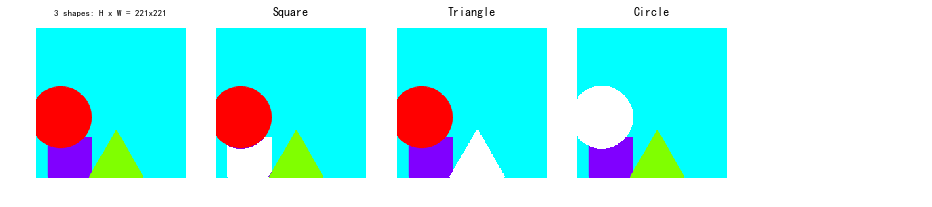

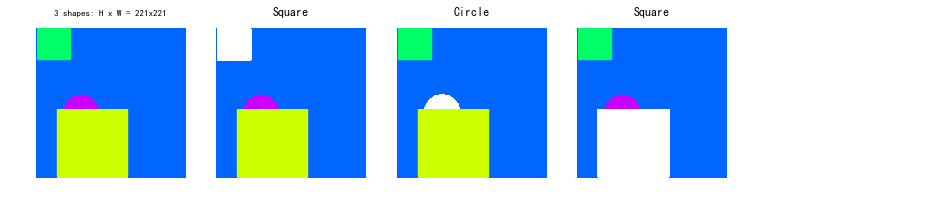

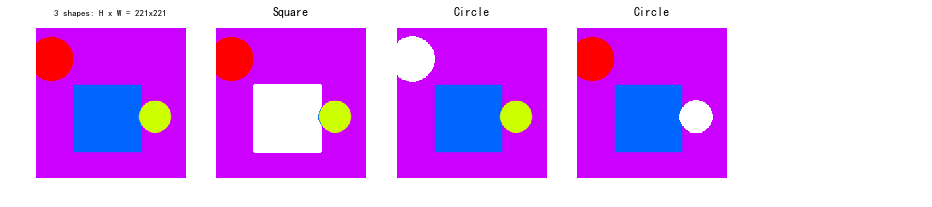

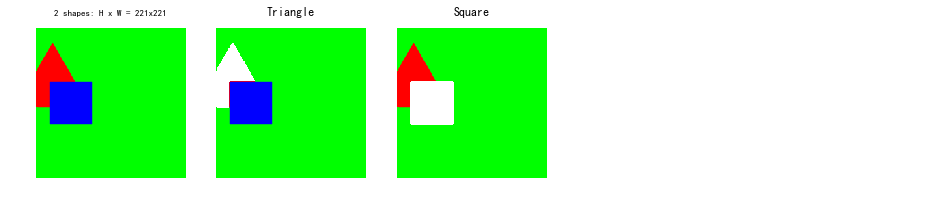

In [11]:
dataset = SyntheticDataset()
dataset.load_synthetic_geometries(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])

N = 4
sample_idx = np.random.choice(range(dataset.count), N)
images_info = dataset.images_info

for idx in sample_idx:
    info = images_info[idx]
    print("images %s info:" % idx)
    print("bg_color", info['bg_color'])
    
    image = dataset.load_image(idx)
    boxes = dataset.load_bbox(idx)
    
    masks, class_ids = dataset.load_mask(idx)
    
    # masked_image = save_instances(image, np.array(boxes), masks, class_ids, dataset.class_names, None)
    # display(masked_image)
    
    n_instances = len(class_ids)
    cols = n_instances
    mask_color = [1, 1, 1]
    
    # Since we have various of columns images for each row, 
    # https://matplotlib.org/3.1.1/tutorials/intermediate/gridspec.html
    
    figsize = (16, int(16 / (N+1)))

    grids_kw = { 
        "wspace": 0.05
    }
    _, axes = plt.subplots(1, N+1, figsize=figsize,
                                      constrained_layout=True,
                                      sharey='all',
                                      gridspec_kw=grids_kw)
    
    if cols == 0:
        axes = [axes]
    display(image, ax=axes[0])
    set_title(axes[0], "{} shapes: H x W = {}x{}".format(len(info['shapes']), image.shape[0], image.shape[1]))
        
    for i in range(n_instances):
        class_id = class_ids[i]
        mask = masks[:, :, i]
        masked_image = image.copy()
        masked_image = apply_mask(masked_image, mask, mask_color, alpha=1.0)
        shape_id = info['shapes'][i][0]
        title = dataset.class_names[shape_id]
        ax = axes[i+1]
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()
        ax.imshow(masked_image.astype(np.uint8), cmap="Blues_r",
                 norm=None, interpolation=None)
    for i in range(n_instances, N):
        ax = axes[i+1]
        ax.axis("off")
        


## YoloV4

YoloV4基于YoloV3. YoloV3由imagenet主干网络，ResNet50, ResNet101, DarkNet，组成其前身是yolo, SSD, 成于Faster RCNN， MaskRCNN之后，以较快的速度、较小的模型参数适用在对推理速度，体积大小要求比较高的实时场景：比如无人车感知模块模块，IOT设备中的摄像头感知模块等。

除了常用的Data Agumentation，BN，Batch-Optimizer选取等技巧，这里参考Stronger Yolov3[1]的研究成果，通过Keras给出实现（见Keras 2 tensorflow代码用于部署），重点对一下组网模块，在合成数据集进行研究。本文还参考了[2]，尤其是paddleCV[3][4], Keras-Yolov3[5], 对实现进行了改进。

- ImageNet特征提取模组
    - ResNet50
    - Darknet
- FPN特征尺度适配模组
- cosine learning rate[1]
- GIOU[2]

在YoloV3输出的每一个像素在深度上，对应一组BBox：每个BBox坐标(4个自由度)，前景概率分数(Objectness)(1个自由度)，以及类别识别分数（C）。因此YoloV3是一个将分类器，回归器都用，回归的目标函数求解的目标检测模型。

```
# Didn't employ anchor in its yolo loss implementation. 
[1] https://github.com/Stinky-Tofu/Stronger-yolo/tree/master/v2
[2] https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/?source=post_page---------------------------
[3] https://github.com/PaddlePaddle/models/tree/develop/PaddleCV/yolov3
[4] http://en.paddlepaddle.org/documentation/docs/en/1.3/api/layers.html#yolov3_loss
[5] https://github.com/qqwweee/keras-yolo3/blob/master/yolo3/model.py
# The first yolov3 implementation. 
[6] https://github.com/ultralytics/yolov3/
# It is actually very similar to [1]. But it didn't reference [1]'s implementation in its readme.md
[7] https://github.com/YunYang1994/tensorflow-yolov3/blob/master/core/yolov3.py
```

In [12]:
import keras
from keras.preprocessing.image import ImageDataGenerator # used for data augumentation
from keras.optimizers import RMSprop, SGD
from keras.callbacks import Callback, EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM

K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [13]:
import os
import keras.utils as keras_utils
import json

ROOT="/home/ma-user/work" # see !pwd
os.system("mkdir -p {}/output".format(ROOT))

CLASS_INDEX = None
CLASS_INDEX_PATH = ('https://storage.googleapis.com/download.tensorflow.org/'
                    'data/imagenet_class_index.json')

cache_dir="{}/output/imagenet".format(ROOT)
if not os.path.isdir(cache_dir):
    os.mkdir(cache_dir)

fpath = keras_utils.get_file(
    'imagenet_class_index.json',
    CLASS_INDEX_PATH,
    cache_subdir=cache_dir,
    file_hash='c2c37ea517e94d9795004a39431a14cb'
)

with open(fpath) as f:
    CLASS_INDEX = json.load(f)
    
print(CLASS_INDEX)

{'0': ['n01440764', 'tench'], '1': ['n01443537', 'goldfish'], '2': ['n01484850', 'great_white_shark'], '3': ['n01491361', 'tiger_shark'], '4': ['n01494475', 'hammerhead'], '5': ['n01496331', 'electric_ray'], '6': ['n01498041', 'stingray'], '7': ['n01514668', 'cock'], '8': ['n01514859', 'hen'], '9': ['n01518878', 'ostrich'], '10': ['n01530575', 'brambling'], '11': ['n01531178', 'goldfinch'], '12': ['n01532829', 'house_finch'], '13': ['n01534433', 'junco'], '14': ['n01537544', 'indigo_bunting'], '15': ['n01558993', 'robin'], '16': ['n01560419', 'bulbul'], '17': ['n01580077', 'jay'], '18': ['n01582220', 'magpie'], '19': ['n01592084', 'chickadee'], '20': ['n01601694', 'water_ouzel'], '21': ['n01608432', 'kite'], '22': ['n01614925', 'bald_eagle'], '23': ['n01616318', 'vulture'], '24': ['n01622779', 'great_grey_owl'], '25': ['n01629819', 'European_fire_salamander'], '26': ['n01630670', 'common_newt'], '27': ['n01631663', 'eft'], '28': ['n01632458', 'spotted_salamander'], '29': ['n01632777', 

In [14]:
# used for decode predictions
!cp ./output/imagenet/imagenet_class_index.json /home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/keras_applications/
# In some machines, you should use "/opt/conda/envs/python36_tf/lib/python3.6/site-packages/keras_applications/" instead. Check sys.executable inside python

## Base Model: DenseNet

DenseNet作为特征提取层具有均衡的准确度和大小尺度。Keras团队的实现的benchmark可以支持这个观点：

<table>
<thead>
<tr>
<th>Model</th>
<th align="right">Size</th>
<th align="right">Top-1 Accuracy</th>
<th align="right">Top-5 Accuracy</th>
<th align="right">Parameters</th>
<th align="right">Depth</th>
</tr>
</thead>
<tbody>
<tr>
<td><a href="#xception">Xception</a></td>
<td align="right">88 MB</td>
<td align="right">0.790</td>
<td align="right">0.945</td>
<td align="right">22,910,480</td>
<td align="right">126</td>
</tr>
<tr>
<td><a href="#vgg16">VGG16</a></td>
<td align="right">528 MB</td>
<td align="right">0.713</td>
<td align="right">0.901</td>
<td align="right">138,357,544</td>
<td align="right">23</td>
</tr>
<tr>
<td><a href="#vgg19">VGG19</a></td>
<td align="right">549 MB</td>
<td align="right">0.713</td>
<td align="right">0.900</td>
<td align="right">143,667,240</td>
<td align="right">26</td>
</tr>
<tr>
<td><a href="#resnet">ResNet50</a></td>
<td align="right">98 MB</td>
<td align="right">0.749</td>
<td align="right">0.921</td>
<td align="right">25,636,712</td>
<td align="right">-</td>
</tr>
<tr>
<td><a href="#resnet">ResNet101</a></td>
<td align="right">171 MB</td>
<td align="right">0.764</td>
<td align="right">0.928</td>
<td align="right">44,707,176</td>
<td align="right">-</td>
</tr>
<tr>
<td><a href="#resnet">ResNet152</a></td>
<td align="right">232 MB</td>
<td align="right">0.766</td>
<td align="right">0.931</td>
<td align="right">60,419,944</td>
<td align="right">-</td>
</tr>
<tr>
<td><a href="#resnet">ResNet50V2</a></td>
<td align="right">98 MB</td>
<td align="right">0.760</td>
<td align="right">0.930</td>
<td align="right">25,613,800</td>
<td align="right">-</td>
</tr>
<tr>
<td><a href="#resnet">ResNet101V2</a></td>
<td align="right">171 MB</td>
<td align="right">0.772</td>
<td align="right">0.938</td>
<td align="right">44,675,560</td>
<td align="right">-</td>
</tr>
<tr>
<td><a href="#resnet">ResNet152V2</a></td>
<td align="right">232 MB</td>
<td align="right">0.780</td>
<td align="right">0.942</td>
<td align="right">60,380,648</td>
<td align="right">-</td>
</tr>
<tr>
<td><a href="#resnet">ResNeXt50</a></td>
<td align="right">96 MB</td>
<td align="right">0.777</td>
<td align="right">0.938</td>
<td align="right">25,097,128</td>
<td align="right">-</td>
</tr>
<tr>
<td><a href="#resnet">ResNeXt101</a></td>
<td align="right">170 MB</td>
<td align="right">0.787</td>
<td align="right">0.943</td>
<td align="right">44,315,560</td>
<td align="right">-</td>
</tr>
<tr>
<td><a href="#inceptionv3">InceptionV3</a></td>
<td align="right">92 MB</td>
<td align="right">0.779</td>
<td align="right">0.937</td>
<td align="right">23,851,784</td>
<td align="right">159</td>
</tr>
<tr>
<td><a href="#inceptionresnetv2">InceptionResNetV2</a></td>
<td align="right">215 MB</td>
<td align="right">0.803</td>
<td align="right">0.953</td>
<td align="right">55,873,736</td>
<td align="right">572</td>
</tr>
<tr>
<td><a href="#mobilenet">MobileNet</a></td>
<td align="right">16 MB</td>
<td align="right">0.704</td>
<td align="right">0.895</td>
<td align="right">4,253,864</td>
<td align="right">88</td>
</tr>
<tr>
<td><a href="#mobilenetv2">MobileNetV2</a></td>
<td align="right">14 MB</td>
<td align="right">0.713</td>
<td align="right">0.901</td>
<td align="right">3,538,984</td>
<td align="right">88</td>
</tr>
<tr>
<td><a href="#densenet">DenseNet121</a></td>
<td align="right">33 MB</td>
<td align="right">0.750</td>
<td align="right">0.923</td>
<td align="right">8,062,504</td>
<td align="right">121</td>
</tr>
<tr>
<td><a href="#densenet">DenseNet169</a></td>
<td align="right">57 MB</td>
<td align="right">0.762</td>
<td align="right">0.932</td>
<td align="right">14,307,880</td>
<td align="right">169</td>
</tr>
<tr>
<td><a href="#densenet">DenseNet201</a></td>
<td align="right">80 MB</td>
<td align="right">0.773</td>
<td align="right">0.936</td>
<td align="right">20,242,984</td>
<td align="right">201</td>
</tr>
<tr>
<td><a href="#nasnet">NASNetMobile</a></td>
<td align="right">23 MB</td>
<td align="right">0.744</td>
<td align="right">0.919</td>
<td align="right">5,326,716</td>
<td align="right">-</td>
</tr>
<tr>
<td><a href="#nasnet">NASNetLarge</a></td>
<td align="right">343 MB</td>
<td align="right">0.825</td>
<td align="right">0.960</td>
<td align="right">88,949,818</td>
<td align="right">-</td>
</tr>
</tbody>
</table>

在上一期，我们通过调整一些感受野尺寸的，数据增强，预训练模型，以及通过增加新算子调整卷积块结构，获得了较强的vgg16模型。除了vgg16，imagenet还涌现了许多模型，但因为没有ROI提取功能，不适合多目标检测，还不是十分实用。现在我们将通过预训练使用它们进行组网，写新的模型YoloV3变种YoloV4.

In [15]:
# loading pretrained model
from keras.applications.densenet import DenseNet169, preprocess_input, decode_predictions
import numpy as np

# exclude fully connected layers
base_model = DenseNet169(include_top=False, weights='imagenet', 
                         input_tensor=None, input_shape=(config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], config.IMAGE_SHAPE[2]), pooling='avg_pool', 
                         classes=config.NUM_CLASSES)

def init_base_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False
    return base_model
        
backbone = init_base_model(base_model)

53182464/53178568 [==============================] - 137s 3us/step


In [16]:
backbone.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 221, 221, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 227, 227, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 111, 111, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 111, 111, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

## YoloV4 Architecture

YoloV4和YoloV3相似。首先通过DarkNet获取3个尺度的特征。至于为什么没有使用FPN的bottom-up和top-down模组组网，是一个需要进一步研究的问题。初步猜测，YoloV3的主要优势还是在比较高的速度上，还获得接近其他模型的准确度，因此为了保持速度优势，没有加入FPN模组组网。



In [17]:
def extract_densenet169_residual_route(backbone):
    """
    Keras denset169 implements 5 stages residual blocks (named as "dense_block"). Each residual blocks
    correspond to sequence of [6, 12, 32, 32].
    
    The numbers of filters of each 2d convolution used for the internal simple residual block are fixed at 128 and 32 with 1x1 and 3x3
    kernels in order.
    
    In this experiment, since we want to use parameters trained on imagenet, we use that simple residual block. However,
    as you can figure out from my other implementation of residual block, we can promise you a better one.
    """
    blocks = []
    model_name = 'densenet169'
    stage_tmpl = "conv{}_block{}_concat"
    conv_repeated_series = [12, 32, 32]
    for seq, conv_repeated in enumerate(conv_repeated_series):
        blocks.append(backbone.get_layer(stage_tmpl.format(seq+3, conv_repeated)))
    return blocks

# Not let's check it
blocks = extract_densenet169_residual_route(backbone)
for block in blocks:
    print(block)
# We've done!

In [18]:
# general intersection over union: https://giou.stanford.edu/
# compared to L1 & L2 norm, jaccard index is scale invariant and have fine scale of values for different overlaps.
# GIoU is especially useful for trainning if we want improve a bad prediction

# All the methods can be generalized to 3d cases and left as future work

# Vallina implementation for IoU
def IoU(left_boxes, right_boxes):
    """
    @param left_boxes: Tensor, shape=(i, 4) x1y1x2y2
    @param right_boxes: Tensor, shape=(j,4), x1y1x2y2
    @return 
        ious: Tensor, shape=(i,j)
        overlap: Tensor, shape=(i,j)
        union: Tensor, shape=(i,j)
    """
    left_boxes = K.expand_dims(left_boxes, -2)
    right_boxes = K.expand_dims(right_boxes, -3)
    # Tensor Broadcasting see https://www.tensorflow.org/xla/broadcasting
    # Since left_boxes, right_boxes are keras tensors, we compute ious using keras operators
    x1y1 = K.maximum(left_boxes[...,:2], right_boxes[...,:2])
    x2y2 = K.minimum(left_boxes[...,2:], right_boxes[...,2:])
    
    # Compute box area: (x2 - x1) * (y2 - y1)
    left_area = (left_boxes[...,2] - left_boxes[...,0]) * (left_boxes[...,3] - left_boxes[...,1])
    right_area = (right_boxes[...,2] - right_boxes[...,0]) * (right_boxes[...,3] - right_boxes[...,1])
    
    # Pay attention to this equation here, the numbers zero should be written as "0.0" to avoid complain from tensorflow backend
    intersected_boxes = K.maximum(0.0, x2y2 - x1y1)
    overlap = intersected_boxes[..., 0] * intersected_boxes[..., 1]
    
    union = left_area + right_area - overlap
    ious = overlap / (union+1e-6)
    return ious, overlap, union

# @todo : TODO
# see this paper : https://arxiv.org/pdf/1608.01471.pdf
def IoU_UnitBox(left_boxes, right_boxes):
    """
    @param left_boxes: Tensor, shape=(i, 4) x1y1x2y2
    @param right_boxes: Tensor, shape=(j,4), x1y1x2y2
    @return ious: Tensor, shape=(i,j)
    """
    pass

def GIoU(left_boxes, right_boxes):
    """
    @param left_boxes: Tensor, shape=(i, 4) x1y1x2y2
    @param right_boxes: Tensor, shape=(j,4), x1y1x2y2
    @return ious: Tensor, shape=(i,j)
    """
    ious, _, union = IoU(left_boxes, right_boxes)
    
    left_boxes = K.expand_dims(left_boxes, -2)
    right_boxes = K.expand_dims(right_boxes, -3)
    # Tensor Broadcasting see https://www.tensorflow.org/xla/broadcasting
    # Since left_boxes, right_boxes are keras tensors, we compute ious using keras operators
    x1y1 = K.minimum(left_boxes[...,:2], right_boxes[...,:2])
    x2y2 = K.maximum(left_boxes[...,2:], right_boxes[...,2:])
    
    # compute minimum convex hull
    # Pay attention to this equation here, the numbers zero should be written as "0.0" to avoid complain from tensorflow backend
    chul = K.maximum(0.0, x2y2 - x1y1)
    chul_area = chul[...,0] * chul[...,1]
    
    gious = ious - (chul_area - union) / chul_area
    return gious
    
def Universal_IoU(left_boxes, right_boxes):
    """
    @param left_boxes: Tensor, shape=(i, 4) x1y1x2y2
    @param right_boxes: Tensor, shape=(j,4), x1y1x2y2
    @return ious: Tensor, shape=(i,j)
    """
    ious, overlap, union = IoU(left_boxes, right_boxes)
    
    left_boxes = K.expand_dims(left_boxes, -2)
    right_boxes = K.expand_dims(right_boxes, -3)
    # Tensor Broadcasting see https://www.tensorflow.org/xla/broadcasting
    # Since left_boxes, right_boxes are keras tensors, we compute ious using keras operators
    x1y1 = K.minimum(left_boxes[...,:2], right_boxes[...,:2])
    x2y2 = K.maximum(left_boxes[...,2:], right_boxes[...,2:])
    
    # compute minimum convex hull
    # Pay attention to this equation here, the numbers zero should be written as "0.0" to avoid complain from tensorflow backend
    chul = K.maximum(0.0, x2y2 - x1y1)
    chul_area = chul[...,0] * chul[...,1]
    
    # uious = uious - (chul_area - union + overlap) / chul_area
    
    # something like items assignment below
    # uious[uious==0] = - (chul_area - union + overlap) / chul_area
    mask = K.equal(ious, 0)
    mask = K.cast(mask, dtype='float32')
    uious = (1-mask)*ious - mask*((chul_area - union + overlap) / chul_area)
    return uious

## Test for Keras GIoU Behaviors

现在我们需要书写测试检测该算子。类似于利用tensorflow的session对象运行算子，我们可以利用keras.backend.function获取从输入tensor，到输出tensor的值。

In [19]:
def test_IoU():
    left_boxes_ops = KL.Input(shape=(1,4))
    right_boxes_ops = KL.Input(shape=(4,4))
    ious_ops, overlap_ops, union_ops= IoU(left_boxes_ops, right_boxes_ops)
    func = K.function([left_boxes_ops, right_boxes_ops], [ious_ops, overlap_ops, union_ops])
    
    left_boxes_vals = np.array([[10, 10, 20, 20]])
    right_boxes_vals = np.array([[12, 12, 22, 22], [15, 15, 25, 25], [25, 25, 35, 45], [30, 30, 50, 40]])
    
    ious, overlap, union = func([left_boxes_vals, right_boxes_vals])
    
    print("IoU computation results:",ious)
    
def test_GIoU():
    left_boxes_ops = KL.Input(shape=(1,4))
    right_boxes_ops = KL.Input(shape=(4,4))
    gious_ops = GIoU(left_boxes_ops, right_boxes_ops)
    func = K.function([left_boxes_ops, right_boxes_ops], [gious_ops])
    
    left_boxes_vals = np.array([[10, 10, 20, 20]])
    right_boxes_vals = np.array([[12, 12, 22, 22], [15, 15, 25, 25], [25, 25, 35, 45], [30, 30, 50, 40]])
    
    gious = func([left_boxes_vals, right_boxes_vals])
    
    print("GIoU computation results:", gious)

def test_UIoU():
    left_boxes_ops = KL.Input(shape=(2,4))
    right_boxes_ops = KL.Input(shape=(4,4))
    uious_ops = Universal_IoU(left_boxes_ops, right_boxes_ops)
    func = K.function([left_boxes_ops, right_boxes_ops], [uious_ops])
    
    left_boxes_vals = np.array([[10, 10, 20, 20], [10, 10, 20, 20]])
    right_boxes_vals = np.array([[12, 12, 22, 22], [15, 15, 25, 25], [25, 25, 35, 45], [30, 30, 50, 40]])
    
    uious = func([left_boxes_vals, right_boxes_vals])
    
    print("UIoU computation results:", uious)
    
# uint test utilites examples here
test_IoU()
test_GIoU()
test_UIoU()

IoU computation results: [[0.47058824 0.14285715 0.         0.        ]]
GIoU computation results: [array([[ 0.41503268, -0.07936507, -0.6571429 , -0.75      ]],
      dtype=float32)]
UIoU computation results: [array([[ 0.47058824,  0.14285715, -0.6571429 , -0.75      ],
       [ 0.47058824,  0.14285715, -0.6571429 , -0.75      ]],
      dtype=float32)]


In [34]:
__author__ = "Lei Wang"
__email__ = ["lwang11@mtu.edu", "L.WANG@ntu.edu.sg", "lwang019@e.ntu.edu.sg", "yiak.wy@gmail.com"]
__date__ = "July 25th, 2019"

# see https://keras.io/activations/
try:
    from keras.layers.advanced_activations import LeakyReLU
except:
    from keras.layers import LeakyReLu
import skimage.transform
try:
    import functools
    from functools import reduce as reduce
except:
    pass

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
def lr_schedule_callback(epoch):
    lr = 1e-2
    if epoch > 75:
        lr = 5*1e-4
    elif epoch > 100:
        lr = 3*1e-4
    return lr

# adpot from mask rcnn : https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/model.py
class BatchNorm(KL.BatchNormalization):
    """Extends the Keras BatchNormalization class to allow a central place
    to make changes if needed.
    Batch normalization has a negative effect on training if batches are small
    so this layer is often frozen (via setting in Config class) and functions
    as linear layer.
    """
    def call(self, inputs, training=None):
        """
        Note about training values:
            None: Train BN layers. This is the normal mode
            False: Freeze BN layers. Good when batch size is small
            True: (don't use). Set layer in training mode even when making inferences
        """
        return super(self.__class__, self).call(inputs, training=training)

def Conv2DBlock(inp, filters, kernel_size=(3, 3), dropouts=None, conv_repeated=1, pooling=False, padding='same', stage=None):
    name = 'conv%s' % stage
    # print("calling %s" % name)
    out = inp
    for i in range(conv_repeated):
        conv = KL.Conv2D(filters, kernel_size, padding=padding, name="{}_conv2d{}".format(name, i))(out)
        bn = BatchNorm(name="{}_bn{}".format(name, i))(conv, training=True)
        # using LeakyRelu with alpah equal to 0.1
        act = KL.LeakyReLU(alpha=0.1, name="{}_act{}".format(name, i))(bn)
        if dropouts is not None and len(dropouts) > 0:
            dropout = KL.Dropout(dropouts[i], name="{}_dp{}".format(name, i))(act)
            out = dropout
        else:
            out = act
    
    if pooling:
        pooled = KL.MaxPooling2D(pool_size=(2,2), name="{}_maxpooling2d{}".format(name_stage))(out)
        out = pooled
    return out

def Conv2DBlockLayer(filters, kernel_size=(3, 3), dropouts=None, conv_repeated=1, pooling=False, padding='same', stage=None):
    # KL.Lamda has some problems in composing functions, hence discarded
    func = KL.Lambda(Conv2DBlock, name="lambda{}".format(stage),
                    arguments={
                        'filters': filters,
                        'kernel_size': kernel_size,
                        'dropouts': dropouts,
                        'conv_repeated': conv_repeated,
                        'pooling': pooling,
                        'padding': padding,
                        'stage': stage
                    })
    func1 = functools.partial(Conv2DBlock, 
                              filters=filters,
                              kernel_size=kernel_size, 
                              dropouts=dropouts, 
                              conv_repeated=conv_repeated, 
                              pooling=pooling, 
                              padding=padding, 
                              stage=stage)
    return func1

def Stack(*funcs):
    """Compose arbitrarily many functions, evaluated left to right.
    Reference: https://mathieularose.com/function-composition-in-python/
    """
    def _stack(pre, cur): 
        # print("produce a composing func")
        def wrapped(*args, **kw):
            # print("call a composing func")
            return cur(pre(*args, **kw))
        return wrapped
    
    if funcs:
        return reduce(lambda pre, cur: _stack(pre, cur), funcs, lambda x: x)
    else:
        raise ValueError('Composition of empty sequence not supported.')

def Conv2BBox(inp, filters, boxes_dim, stage):
    if not isinstance(stage, str):
        stage = str(stage)
    print("Conv2BBox inp", inp)
    assert_symbolic_tensor(inp)
    conv = Stack(
        Conv2DBlockLayer(filters, (1,1), stage=stage+"/1"),
        Conv2DBlockLayer(filters*2, (3,3), stage=stage+"/2"),
        Conv2DBlockLayer(filters, (1,1), stage=stage+"/3"),
        Conv2DBlockLayer(filters*2, (3,3), stage=stage+"/4"),
        Conv2DBlockLayer(filters, (1,1), stage=stage+"/5")
    )(inp)
    assert_symbolic_tensor(conv)
    out = Stack(
        Conv2DBlockLayer(filters*2,(3,3), stage=stage+"/6"),
        KL.Conv2D(boxes_dim, (1,1), name="conv{}_conv2d{}".format(stage+"/7", 0))
    )(conv)
    return conv, out

def UpSampling_BilinearInterpolation(inp, factor):
    return KL.UpSampling2D(size=(factor, factor))(inp)

def Decode(feat, anchors_per_grid, num_classes, anchors):
    """
    Decode feature map to bounding boxes with shape = (batch_size, out_nm_h, out_nm_w, anchors_per_grid * (5+num_classes))
    
    :param feat: Tensor, shape=(batch_size, out_nm_h, out_nm_w, anchors_per_grid * (5+num_classes))
    :param anchors_per_grid: integer, anchors per sliding window
    :num_classes: numbers of classes to predict
    :stride: 
    :return
        pred_bbox: Tensor, shape=(batch_size, out_nm_h, out_nm_w, anchors_per_grid * (5+num_classes))
    """
    shape = K.shape(feat)
    batch_size = shape[0]
    out_nm = shape[1:3]
    
    # Create XY Grid:
    # Just like create a grid in numpy using np.tile and np.arange
    # >>> y = np.tile(np.arange(3).reshape(3,1), [1, 4])
    # array([[0, 0, 0, 0],
    #        [1, 1, 1, 1],
    #        [2, 2, 2, 2]])
    # >>> x = np.tile(np.arange(4).reshape(1,4), [3, 1])
    # array([[0, 1, 2, 3],
    #        [0, 1, 2, 3],
    #        [0, 1, 2, 3]])
    # >>> grid = np.concatenate([np.expand_dims(x, axis=-1), np.expand_dims(cy axis=-1)], axis=-1) # shape=(3,4,2)
    # array([[[0, 0],
    #         [1, 0],
    #         [2, 0],
    #         [3, 0]],
    #
    #        [[0, 1],
    #         [1, 1],
    #         [2, 1],
    #         [3, 1]],
    #
    #        [[0, 2],
    #         [1, 2],
    #         [2, 2],
    #         [3, 2]]])
    grid_y  = K.tile(K.expand_dims(K.arange(0, stop=out_nm[0]), axis=1), [1, out_nm[1]]) #repeat along width direction
    grid_x  = K.tile(K.expand_dims(K.arange(0, stop=out_nm[1]), axis=0), [out_nm[0], 1]) #repeat along height direction 
    grid_xy = K.concatenate([K.expand_dims(grid_x, axis=-1), K.expand_dims(grid_y, axis=-1)], axis=-1)
    grid_xy = K.cast(grid_xy, K.dtype(feat))
    
    feat = K.reshape(feat, [-1, out_nm[0], out_nm[1], anchors_per_grid, 5+num_classes])
    anchor_tensor = K.reshape(K.constant(anchors), [1,1,1, anchors_per_grid, 2])
    grid_shape = out_nm
    
    # Yolo predicts offsets (dx, dy, dh, dw) and adjust boxes generated from anchors instead of predicting bbox coordinates where
    # bx = (cx + sigmoid(dx)) * downsampling_rate
    # by = (cy + sigmoid(dy)) * downsampling_rate
    # bh = exp^dh * anchor_h  * downsampling_rate
    # bw = exp^dw * anchor_w  * downsampling_rate
    # where, downsampling_rate = input_shape / grid_shape (shape=(2,1))
    # For Coco dataset we could use prior anchor sizes computed via K-Means++ : 10x13，16x30，33x23，30x61，62x45，59x119，116x90，156x198，373x326
    # See [MetaAnchor: Learning to Detect Objects with Customized Anchors](https://arxiv.org/abs/1807.00980?source=post_page---------------------------) and
    # https://www.liip.ch/en/blog/face-detection-an-overview-and-comparison-of-different-solutions-part1?source=post_page---------------------------
    
    # Compute normalized bboxes
    bboxes_xy = grid_xy + K.sigmoid(feat[...,:2]) / K.cast(grid_shape[::-1], K.dtype(feat))
    bboxes_wh = K.exp(feat[..., 2:4]) * anchor_tensor / K.cast(grid_shape[::-1], K.dtype(feat))
    bboxes_x1y1 = bboxes_xy - bboxes_wh / 2.0
    bboxes_x2y2 = bboxes_xy + bboxes_wh / 2.0
    pred_corner = K.concatenate([bboxes_x1y1, bboxes_x2y2], axis=-1)
    
    # logloss of confidence
    pred_conf = K.sigmoid(feat[..., 4:5])
    
    # logloss of One-Hot encoding of predicted classes
    pred_class_probs = K.sigmoid(feat[..., 5:])
    
    pred_bboxes = K.concatenate([pred_corner, pred_conf, pred_class_probs], axis=-1)
    return pred_bboxes

def assert_symbolic_tensor(inp):
    try:
        K.is_keras_tensor(inp)
    except ValueError as e:
        raise(e)

# also see implementation for other models in SpatialDetectron
class YoloV4(object):
    
    def __init__(self, mode, config, model_dir,
                 backbone=None):
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.backbone = backbone
        self.inputs = None
        self.outputs = None
        self.scales = [32, 16, 8]
        self.anchors = {2: [(10,13),(16,30),(33,23)],     # large objects detect anchors
                        1: [(30,61),(62,45),(59,119)],    # medium objects detect anchors
                        0: [(116,90),(156,198),(373,326)]} # smallest detect anchors
        self.anchors_per_grid = 3
        self.iou_loss_threshold = 0.7
        # Here we use customer loss
        self.model = self.get_model(mode=self.mode, backbone=self.backbone)
        
    def get_model(self, mode, backbone):
        config = self.config
        # Darknet features pyramid (similar to FPN without top-down network block and restricted to 3 feature layers extraction)
        if backbone is None:
            base_model = DenseNet169(include_top=False, weights='imagenet', 
                         input_tensor=None, input_shape=(config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], config.IMAGE_SHAPE[2]), pooling='avg_pool', 
                         classes=config.NUM_CLASSES)
            backbone = init_base_model(base_model)
            
        blocks = extract_densenet169_residual_route(backbone)
        
        self.inputs = backbone.inputs
        self.input_size = K.shape(self.inputs[0]) 
        H, W, CHANNELS = config.IMAGE_SHAPE
        self.outputs = []
        
        # YoloV4 Detectron Body
        # make bolcks in reverse order
        blocks = blocks[::-1]
        # the darknet output for small objects
        x = blocks[0].output
        assert_symbolic_tensor(x)
        boxes_dim = self.anchors_per_grid * (config.NUM_CLASSES+5)
        filters = [512, 256, 128] # config
        self.featmaps = []
        for i, block in enumerate(blocks):
            if i > 0:
                x = Conv2DBlock(x, filters[i], (1,1), stage=str(i)+"/0")
                x = UpSampling_BilinearInterpolation(x, 2)
                x = KL.Concatenate()([x, block.output])
                
            x, out = Conv2BBox(x, filters[i], boxes_dim, stage=i)
            print("Add featmap %s" % i)
            self.featmaps.append(out)
        
        # YoloV3 Losses: the key part of the detectron
        # In practice self.anchors_per_grid == gt_per_grid makes loss easy to be expressed via tensor operations
        scales = [32, 16, 8] # config
        y_true = [KL.Input(shape=(int(H/scale), 
                                  int(W/scale), 
                                  self.anchors_per_grid, config.NUM_CLASSES+5)) for scale in scales]
        import inspect
        inspect.signature(self.loss)
        loss = KL.Lambda(self.loss, output_shape=(1,), name="yolo_loss",
                         arguments={'y_true': y_true})(self.featmaps)
        self._loss = loss
        
        # Model
        # calling to keras.engine.network.Network._init_graph_network (L137) method to initialize computational graph
        model = KM.Model([self.inputs[0], *y_true], loss)
        return model
    
    # The most important function
    # also see decode func (which is the reference implementation for loss) in https://github.com/Stinky-Tofu/Stronger-yolo/blob/master/v2/model/layers.py
    def loss(self, featmaps, y_true):
        config = self.config
        losses = 0.0
        for i,fm in enumerate(featmaps):
            # compute normalized predicted bbox
            print("Shape of fm:", fm.get_shape())
            pred_bboxes = Decode(fm, self.anchors_per_grid, config.NUM_CLASSES, self.anchors[i])
            print("Shape of pred_bboxes:", pred_bboxes.get_shape())
            shape = K.shape(fm)
            out_nm = shape[1:3]
            fm = K.reshape(fm, [-1, out_nm[0], out_nm[1], self.anchors_per_grid, 5+config.NUM_CLASSES])
            print("Shape of fm after dimension expansion:", fm.get_shape())
            batch_size = self.input_size[0]
            # important!
            batch_size = K.cast(batch_size, K.dtype(fm))
            
            # loss of predicted bounding boxes using Universal_IoU
            # uious tensor of the shape [batch_size, h, w, anchor_per_grid, gt_per_grid], where anchor_per_grid == gt_per_grid in practice
            uious = Universal_IoU(pred_bboxes[..., 0:4], y_true[i][..., 0:4])
            gt_hw = y_true[i][...,2:4]
            # weights tensor of the shape [batch_size, h, w, gt_per_grid, 1]
            weights = 2.0 - gt_hw[...,0:1] * gt_hw[...,1:2]
            fg_mask = y_true[i][..., 4:5]
            uious_loss = fg_mask * weights * (1-uious)
            
            # loss of confidence
            ious, _, _= IoU(pred_bboxes[...,0:4], y_true[i][..., 0:4])
            print("Shape of ious:", ious.get_shape())
            # see implementation of K.max at https://github.com/keras-team/keras/blob/master/keras/backend/tensorflow_backend.py
            # it is equivalent to tf.reduce_max
            max_ious = K.max(ious, axis=-1)
            print("Shape of max_ious:", max_ious.get_shape())
            max_ious = K.expand_dims(max_ious, axis=-1)
            print("Shape of max_ious after expansion:", max_ious.get_shape())
            # [batch_size, h, w, gt_per_grid, 1] * [batch_size, h, w, anchor_per_grid, 1]
            bg_mask = (1.0 - fg_mask) * K.cast(max_ious < self.iou_loss_threshold, dtype='float32')
            alpha = 1
            gamma = 2
            conf_focal = alpha * K.pow(K.abs(fg_mask-pred_bboxes[...,4:5]), gamma) # L2 norm
            print("Shape of fm[...,4:5]:", fm[...,4:5].get_shape())
            conf_loss = conf_focal * (
                fg_mask * K.binary_crossentropy(fg_mask, fm[...,4:5], from_logits=True)
                +
                bg_mask * K.binary_crossentropy(fg_mask, fm[...,4:5], from_logits=True)
            )
            
            # loss of one-hot encoding of classes
            class_probs_loss = fg_mask * K.binary_crossentropy(y_true[i][...,5:], fm[...,5:], from_logits=True)
            
            # gather total loss
            print("type of uious_loss:", K.dtype(uious_loss))
            print("type of conf_loss:", K.dtype(conf_loss))
            print("type of class_probs_loss:", K.dtype(class_probs_loss))
            loss = (K.sum(uious_loss) + K.sum(conf_loss) + K.sum(class_probs_loss)) / batch_size
            losses += loss
        return losses
    
    def fit(self, dataset, optimizer_type='rmsprop', data_gen=True, data_augumented=True):
        model = self.model
        # Initate optimizer
        if optimizer_type is 'rmsprop':
            optimizer = RMSprop(lr=1e-2, decay=1e-6)
        else:
            optimizer = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=False)
        # compile the program
        model.compile(loss={
            'yolo_loss': lambda y_true, y_pred: ypred
        }, optimizer=optimizer, metrics=['accuracy'])
        
        # early stopping strategy
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto') 
        history = LossHistory()
        
        filepath="{}/weights.best.checkpoint.hdf5".format(self.model_dir)
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        
        learning_rate_schedule = LearningRateScheduler(lr_schedule_callback)
        
        if data_augumented:
            # data augumentation
            # adapted from https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
            datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                zca_epsilon=1e-06,  # epsilon for ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                # randomly shift images horizontally (fraction of total width)
                width_shift_range=0.1,
                # randomly shift images vertically (fraction of total height)
                height_shift_range=0.1,
                shear_range=0.,  # set range for random shear
                zoom_range=0.,  # set range for random zoom
                channel_shift_range=0.,  # set range for random channel shifts
                # set mode for filling points outside the input boundaries
                fill_mode='nearest',
                cval=0.,  # value used for fill_mode = "constant"
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False,  # randomly flip images
                # set rescaling factor (applied before any other transformation)
                rescale=None,
                # set function that will be applied on each input
                preprocessing_function=None,
                # image data format, either "channels_first" or "channels_last"
                data_format=None,
                # fraction of images reserved for validation (strictly between 0 and 1)
                validation_split=0.25)
        
        # begin to train
        if not data_gen:
            # load a small dataset for test in CPU mode and generate train_data, train_annotations to feed model
            # @todo : TODO
            raise Exception("train_data, train_annotations without data_gen are not implemented.")
            # fit model using train data
            model.fit(
                train_data,
                train_annotations,
                batch_size=self.config.BATCH_SIZE,
                epochs=self.config.EPOCHES,
                validation_split=0.25, # trainning, 25% of data used for validation
                verbose=2,
                shuffle=True,
                callbacks=[history, early_stopping, checkpoint, learning_rate_schedule])
        else:
            # trainning for large scale datasets
            train_reader = dataset.train_reader()
            val_reader = dataset.infer_reader()

            model.fit_generator(train_reader,
                                validation_data=val_reader,
                                epochs=self.config.EPOCHES,
                                workers=8,
                                verbose=2,
                                callbacks=[history, checkpoint])
        
        return history
    
    def load_weights(self, weights=None):
        if weights is None:
            filepath="{}/weights.best.checkpoint.hdf5".format(self.model_dir)
        else:
            filepath=weights
            
        if os.path.isfile(filepath):
            model = self.model
            model.load_weights(filepath)
        else:
            print("{} does not exit!".format(filepath))
    
    def infer(self, imgs, verbose=0):
        model = self.model
        results = model.predict(imgs, verbose=verbose)
        return results
    
    def summary(self):
        self.model.summary()
    
    def get_layers(self):
        return self.model.layers
        

In [35]:
Model_Dir="{}/output/synthetic".format(ROOT)
if not os.path.isdir(Model_Dir):
    os.mkdir(Model_Dir)

config = SyntheticDatasetConfig()
model = YoloV4("training", config, Model_Dir, backbone=backbone)
model.summary()

Conv2BBox inp Tensor("conv5_block32_concat/concat:0", shape=(?, 7, 7, 1664), dtype=float32)
Add featmap 0
Conv2BBox inp Tensor("concatenate_15/concat:0", shape=(?, 14, 14, 1536), dtype=float32)
Add featmap 1
Conv2BBox inp Tensor("concatenate_16/concat:0", shape=(?, 28, 28, 640), dtype=float32)
Add featmap 2
Shape of fm: (?, 7, 7, 27)
Shape of pred_bboxes: (?, ?, ?, 3, 9)
Shape of fm after dimension expansion: (?, ?, ?, 3, 9)
Shape of ious: (?, 6, 6, 3, 3)
Shape of max_ious: (?, 6, 6, 3)
Shape of max_ious after expansion: (?, 6, 6, 3, 1)
Shape of fm[...,4:5]: (?, ?, ?, 3, 1)
type of uious_loss: float32
type of conf_loss: float32
type of class_probs_loss: float32
Shape of fm: (?, 14, 14, 27)
Shape of pred_bboxes: (?, ?, ?, 3, 9)
Shape of fm after dimension expansion: (?, ?, ?, 3, 9)
Shape of ious: (?, 13, 13, 3, 3)
Shape of max_ious: (?, 13, 13, 3)
Shape of max_ious after expansion: (?, 13, 13, 3, 1)
Shape of fm[...,4:5]: (?, ?, ?, 3, 1)
type of uious_loss: float32
type of conf_loss: flo

conv4_block8_0_relu (Activation (None, 14, 14, 480)  0           conv4_block8_0_bn[0][0]          
__________________________________________________________________________________________________
conv4_block8_1_conv (Conv2D)    (None, 14, 14, 128)  61440       conv4_block8_0_relu[0][0]        
__________________________________________________________________________________________________
conv4_block8_1_bn (BatchNormali (None, 14, 14, 128)  512         conv4_block8_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block8_1_relu (Activation (None, 14, 14, 128)  0           conv4_block8_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block8_2_conv (Conv2D)    (None, 14, 14, 32)   36864       conv4_block8_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_bloc

In [ ]:
import timeit

start = timeit.default_timer()
# For large dataset, we prefer to use `SGD` and data generator `datagen` to digest dataset quickly
model.fit(dataset, optimizer_type='sgd')
elapsed = timeit.default_timer() - start



